In [1]:
import sys
sys.path.append('../../../utils/')
from cmptTheoreticalEmitGrowth import *
from bunchLengthConversions import *
from coordinatesConversions import *
from cmpt_TuneSpreads import *

import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

### Plotting parameters

In [2]:
params = {'legend.fontsize': 20,
          'figure.figsize': (9.5, 8.5),
          'axes.labelsize': 27,
          'axes.titlesize': 23,
          'xtick.labelsize': 27,
          'ytick.labelsize': 27,
          'image.cmap': 'jet',
          'lines.linewidth': 1,
          'lines.markersize': 10,
          'font.family': 'sans-serif'}

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

### Study parameters

In [9]:
n_sets = 20
n_turns = int(1e5)            # number of cycles to run the simulation for
decTurns = int(100)           # how often to record data
circumference  = 6911.5623 # [m]
f_rev  = 299792458/circumference  # [Hz] The revolution frequency of the machine 
separationTime = 1 / f_rev * decTurns #There are decTurns revolutions before each recording of data
tspan = (np.arange(n_turns / decTurns) + 1.0) * separationTime #total time spanned by the simulation

In [10]:
my_start = 400.0 #9.6e3 #400.0
my_stop =  1.6e4#1.6e4 #1.6e4
my_step = 800.0

my_variables = list(np.arange(my_start, my_stop, my_step))
my_variables.insert(0,0.0)
print(my_variables)
print(len(my_variables))

[0.0, 400.0, 1200.0, 2000.0, 2800.0, 3600.0, 4400.0, 5200.0, 6000.0, 6800.0, 7600.0, 8400.0, 9200.0, 10000.0, 10800.0, 11600.0, 12400.0, 13200.0, 14000.0, 14800.0, 15600.0]
21


### Load the data

In [11]:
path_to_data = './'
study_name = 'deyRates_sps_270GeV_CC_PN1e-8_1e5turns_5e5Nb_wakefieldsONvsOFF_QpxQpy5e-1_ayyScanlong' # title for save figures
studies_list= ['deyRates_sps_270GeV_CC_PN1e-8_1e5turns_5e5Nb_Nowakefields_QpxQpy0_ayyScan', 'deyRates_sps_270GeV_CC_PN1e-8_1e5turns_5e5Nb_Nowakefields_QpxQpy5e-1_ayyScan', 'deyRates_sps_270GeV_CC_PN1e-8_1e5turns_5e5Nb_Nowakefields_QpxQpy1_ayyScan', 'deyRates_sps_270GeV_CC_PN1e-8_1e5turns_5e5Nb_Nowakefields_QpxQpy2_ayyScan']
label_list = ['Qpx=Qpy=0', 'Qpx=Qpy=0.5', 'Qpx=Qpy=1', 'Qpx=Qpy=2']

### Compute the theroetically expected rate

In [12]:
noise_type ='PN'
# Machine parameters
betay = 73.81671646 # 73 m at CC2, 76 m at CC1
Vcc = 1e6 # V
Eb = 270e9 # eV
gamma_0 = 287.8 
beta_0 = np.sqrt(1 - 1/gamma_0**2)
circumference = 6911.5623 # m
frev = 299792458/circumference # Hz
sigma_z = 0.155 # m
f_CC = 400.789e6 # CC frequency in Hz
clight = 299792458 # m/s
# Noise kick parameters
A_phase = 1e-8 # rms kick in the simulation of the phase noise
A_amplitude = 0 # rms kick in the simulation of the amplitude noise
scale_factor = Eb/Vcc # scaling factor to rms noise, σ
# Compute the PSD in rad^2/Hz and V^2/Hz
PSD_phi = (A_phase * scale_factor)**2/frev # rad^2/Hz
#PSD_phi = 1.42e-10
#PSD_phi = 1.4e-10
PSD_A = (A_amplitude * scale_factor)**2/frev # V^2/Hz
print(f'psd phi: {PSD_phi} rad^2/Hz, psd A: {PSD_A} V^2/Hz')

psd phi: 1.6806723392287607e-10 rad^2/Hz, psd A: 0.0 V^2/Hz


In [13]:
# Compute the correction factor due to the bunch length
sigma_phi = bunch_length_m_to_rad(sigma_z, clight, f_CC)
CDeltaphi = cmpt_bunch_length_correction_factor(sigma_phi, 'PN')
CDeltaA = cmpt_bunch_length_correction_factor(sigma_phi, 'AN')
print('CDeltaPhi = {}, CDeltaA = {}'.format(CDeltaphi, CDeltaA))

if noise_type == 'PN':
    expected_growth = emit_growth_phase_noise(betay, Vcc, frev, Eb, CDeltaphi, PSD_phi, one_sided_psd=False)*beta_0*gamma_0 # m/s
    my_color = 'C0'
    fill_bewtween_color = 'lightblue'
elif noise_type == 'AN':
    expected_growth = emit_growth_amplitude_noise(betay, Vcc, frev, Eb, CDeltaA, PSD_A, one_sided_psd=False)*beta_0*gamma_0 # m/s
    my_color = 'C1'
    fill_bewtween_color = 'moccasin'
else:
    my_color = 'C2'
    expected_growth_1 = emit_growth_phase_noise(betay, Vcc, frev, Eb, CDeltaphi, PSD_phi, one_sided_psd=False)*beta_0*gamma_0 # m/s
    expected_growth_2 = emit_growth_amplitude_noise(betay, Vcc, frev, Eb, CDeltaA, PSD_A, one_sided_psd=False)*beta_0*gamma_0 # m/s
    expected_growth = expected_growth_1 + expected_growth_2

print('expected growth = {} nm/s'.format(expected_growth*1e9))

CDeltaPhi = 0.5168486015622045, CDeltaA = 0.24157569921889774
expected growth = 23.813362141833874 nm/s


### Compute the rms detuning with amplitude

In [14]:
#Load the bunch, you need to activate a Pyheadtail version v1.13 or newer
#path_to_bunch = '/afs/cern.ch/work/n/natriant/private/pyheadtail_example_crabcavity/'
#study_name_dq = 'sps_270GeV_CC_PN1e-8_1e5turns_5e5Nb_wakefieldsON_500slices_QpxQpy2_ayy0.0_fixedKicksSet1_run0/'
path_to_bunch = './'
bunch = pickle.load(open(path_to_bunch+'bunch', 'rb')) # you need to activate an environment with pyhedtail version at least v1.13.5

In [15]:
# Optics at CC2
beta_y = 73.81671646
beta_x = 30.31164764
alpha_y = 0
alpha_x = 0

# Coordinates
x, px = bunch.x, bunch.xp
y, py =  bunch.y, bunch.yp

# Normalised coordinates 
x_n, px_n = cmpt_normalised_coordinates(x, px, beta_x, alpha_x)
y_n, py_n = cmpt_normalised_coordinates(y, py, beta_y, alpha_y)


# Compute actions
Jx_init = cmpt_actions(x_n, px_n)
Jy_init = cmpt_actions(y_n, py_n)

rms_Jx_init = np.std(Jx_init)
rms_Jy_init = np.std(Jy_init)

print(f'rms(Jx)={rms_Jx_init} m')
print(f'rms(Jy)={rms_Jy_init} m')

rms(Jx)=6.9400568591152065e-09 m
rms(Jy)=6.936692592779671e-09 m


In [19]:
Dqy_rms = []
axy=0
for ayy in my_variables:
    Dqy_rms.append(rms_amplitude_detuning_y(Jy_init, Jx_init, ayy, axy))

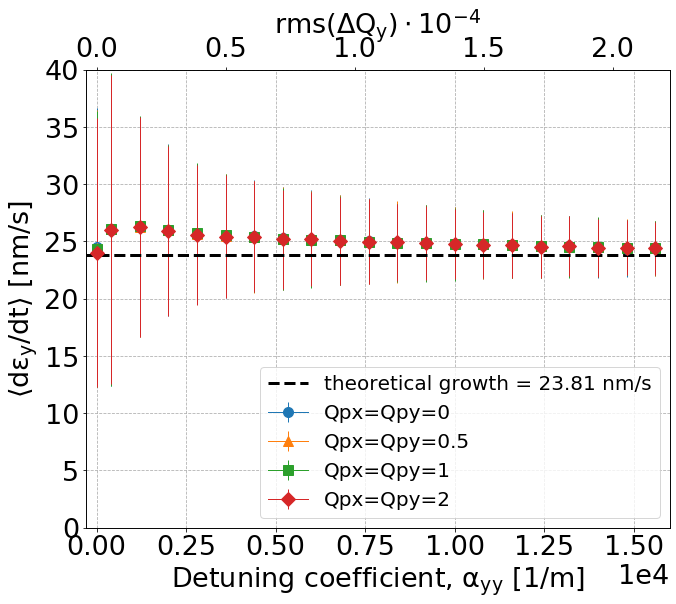

In [21]:
fig, ax = plt.subplots(1,1)

markers = ['o', '^', 's', 'D']
for index, study in enumerate(studies_list):
    my_df = pickle.load(open(path_to_data+study+'.pkl', 'rb'))
    my_df_keys = list(my_df.keys()) 
    
    for i, key in enumerate(my_df_keys):
        # compute error bars
        systematic_error = np.std(my_df[my_df_keys[i]]['m'])
        statistical_error = np.sqrt(np.mean(np.array(my_df[my_df_keys[i]]['err'])**2))
        total_error = np.sqrt(systematic_error**2+statistical_error**2)

        if i == 0:
            plt.errorbar(my_variables[i], np.mean(my_df[my_df_keys[i]]['m'])*1e9, yerr=total_error*1e9, marker=markers[index],  c=f'C{index}', label=label_list[index])
        else:
            plt.errorbar(my_variables[i], np.mean(my_df[my_df_keys[i]]['m'])*1e9, yerr=total_error*1e9, marker=markers[index],  c=f'C{index}')#, label=my_label_2)

ax2 = ax.twiny()
ax2.plot(np.array(Dqy_rms)*1e4, np.arange(0,len(my_variables)), linestyle='')


ax.hlines(expected_growth*1e9, -400, 17000, linestyles='dashed', linewidth=3, color='k', label=f'theoretical growth = {expected_growth*1e9:.2f} nm/s')
ax.legend(loc=4)

ax2.set_xlim(-2*300*rms_Jy_init*1e4, 2*16000*rms_Jy_init*1e4)
ax.set_xlim(-300, 16000)

ax.set_ylim(0, 40)
ax.grid(linestyle='dashed')

ax.set_ylabel(r'$\mathrm{\langle d\epsilon_y / dt \rangle \ [nm/s]}$')
ax.set_xlabel('Detuning coefficient, '+r'$\mathrm{\alpha_{yy} \ [1/m]}$')
ax.ticklabel_format(axis='x', style='sci', scilimits=(4,4))


ax2.set_xlabel(r'$\mathrm{rms(\Delta Q_y) \cdot 10^{-4}}$')

plt.tight_layout()

savefig = False
if savefig:
    plt.savefig(f'./output/{study_name}_vs_Nowakes_TuneSpread_QpxQpyScan.png', bbox_inches='tight')

### Computation of the error bars

Let's assume:

\begin{equation}
y_1 = a_1 x \pm err_1 \\
y_2 = a_2 x \pm err_2 \\
y_3 = a_3 x \pm err_3
\end{equation}

where $a_1, a_2, a_3$ is the growth rates obtained from a linear fit on the simulation data and $err_1, err_2, err_3$ the error of the linear fit. 


Then the systematic error is:
\begin{equation}
systematic \ error = std({a_1, a_2, a_3})
\end{equation}

and the statistical errors:
\begin{equation}
statistical \ error = \sqrt{\langle {err_1^2, err_2^2. err_3^2} \rangle} 
\end{equation}.

The total error is:

\begin{equation}
total \ error = \sqrt{(systematic \ error)^2 + (statistical \ error)^2}
\end{equation}